In [1]:
!nvidia-smi

Sun Jan 19 13:07:49 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install googletrans==3.1.0a0
!pip install --upgrade diffusers transformers -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=83f91d136af3a0ed0a5e8fde1abe85e22a5fe93c48793df5775583aa744cc7f1
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succe

In [4]:
from googletrans import Translator
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import cv2

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [7]:
def get_translation(text, dest_lang):
  translator = Translator()
  translated_text = translator.translate(text, dest=dest_lang)
  return translated_text.text

In [8]:
class CFG:
  device = "cuda"
  seed = 42

  try:
    generator = torch.Generator(device).manual_seed(seed)
  except Exception as e:
    print(f"Error: {e}")
    device = "cpu"
    generator = torch.Generator(device).manual_seed(seed)

  image_gen_steps = 35
  image_gen_model_id = "stabilityai/stable-diffusion-2-1"
  image_gen_size = (900,900)
  image_gen_guidance_scale = 9
  prompt_gen_model_id = "gpt-omni/mini-omni"
  prompt_dataset_size = 6
  prompt_max_lenghth = 12

In [9]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype = torch.float16,
    revision='fp16', use_auth_token= '', guidance_scale=9
)

image_gen_model = image_gen_model.to(CFG.device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/517 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': '', 'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [10]:
def generate_image(prompt, model):
  image = model(
      prompt, num_inference_steps=CFG.image_gen_steps,
      generator = CFG.generator,
      guidance_scale=CFG.image_gen_guidance_scale
  ).images[0]


  image = image.resize(CFG.image_gen_size)
  return image

  0%|          | 0/35 [00:00<?, ?it/s]

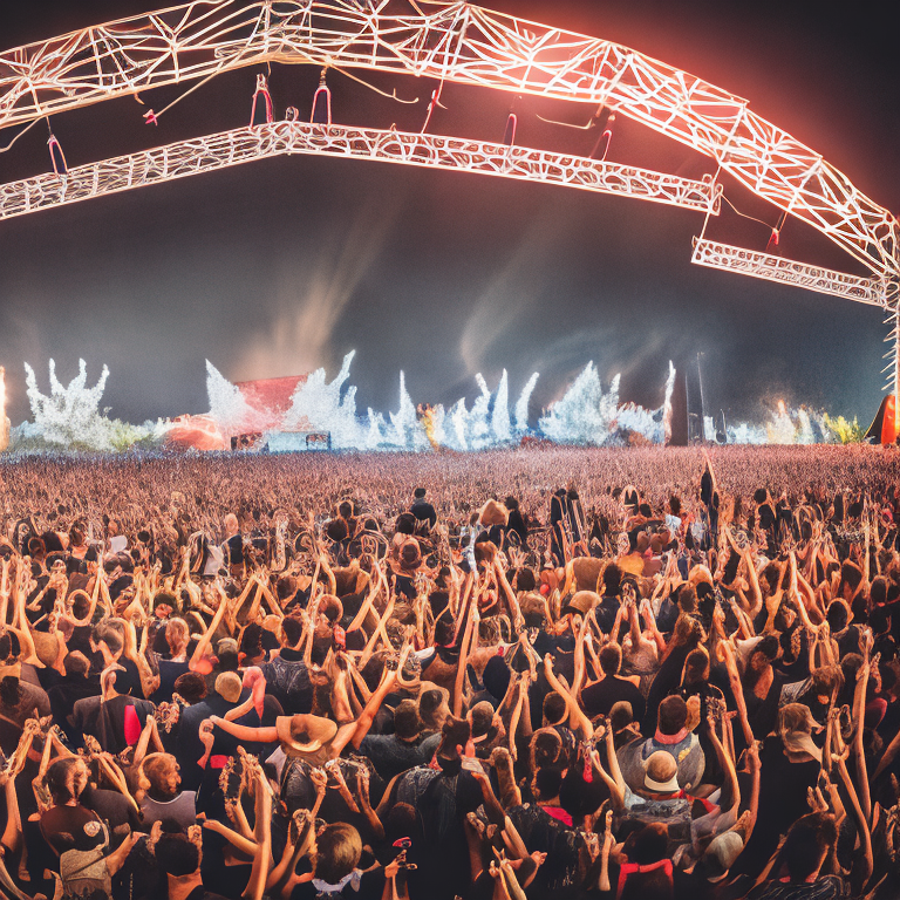

In [11]:
translation = get_translation("Roskilde Festival","en")
generate_image(translation, image_gen_model)

  0%|          | 0/35 [00:00<?, ?it/s]

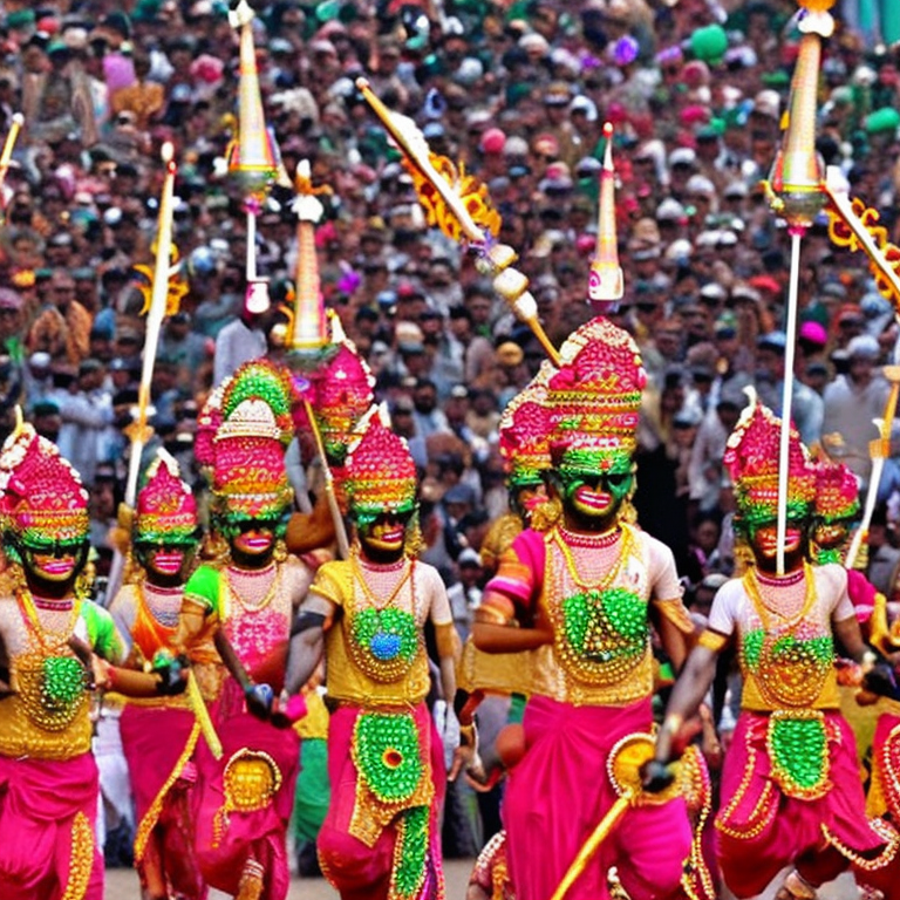

In [18]:
translation = get_translation("తెలంగాణ దసరా పండుగ","en")
generate_image(translation, image_gen_model)

  0%|          | 0/35 [00:00<?, ?it/s]

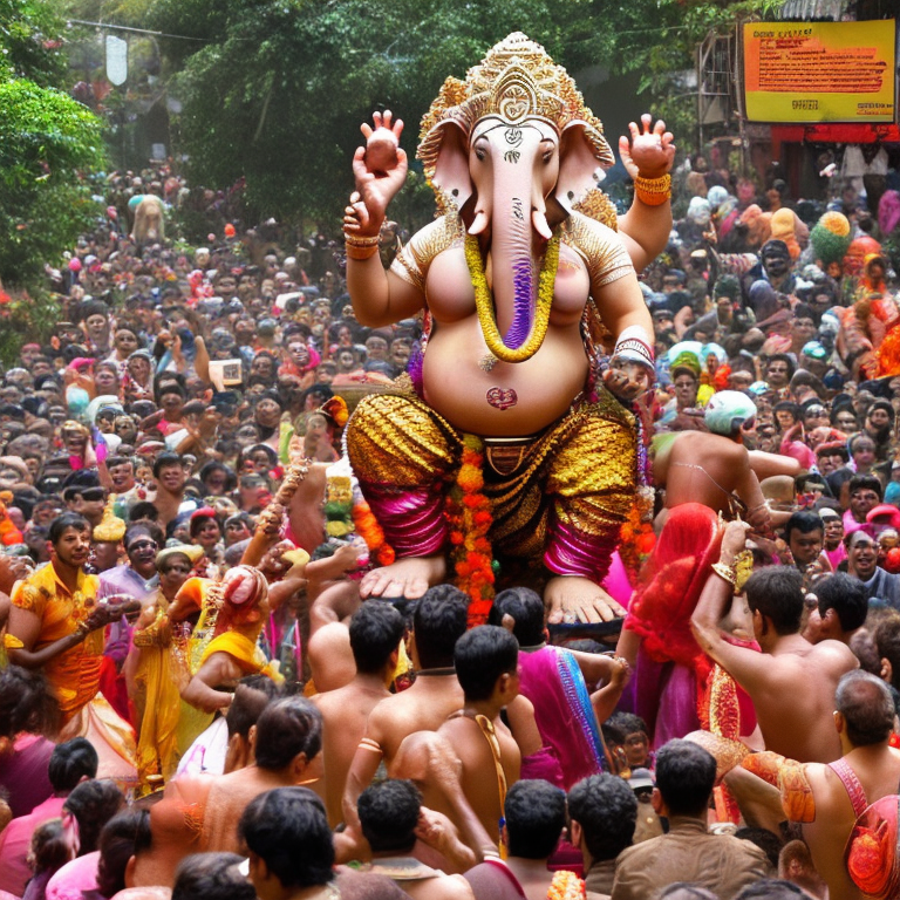

In [17]:
translation = get_translation("भारतीय उत्सव गणेश विसर्जन","en")
generate_image(translation, image_gen_model)

  0%|          | 0/35 [00:00<?, ?it/s]

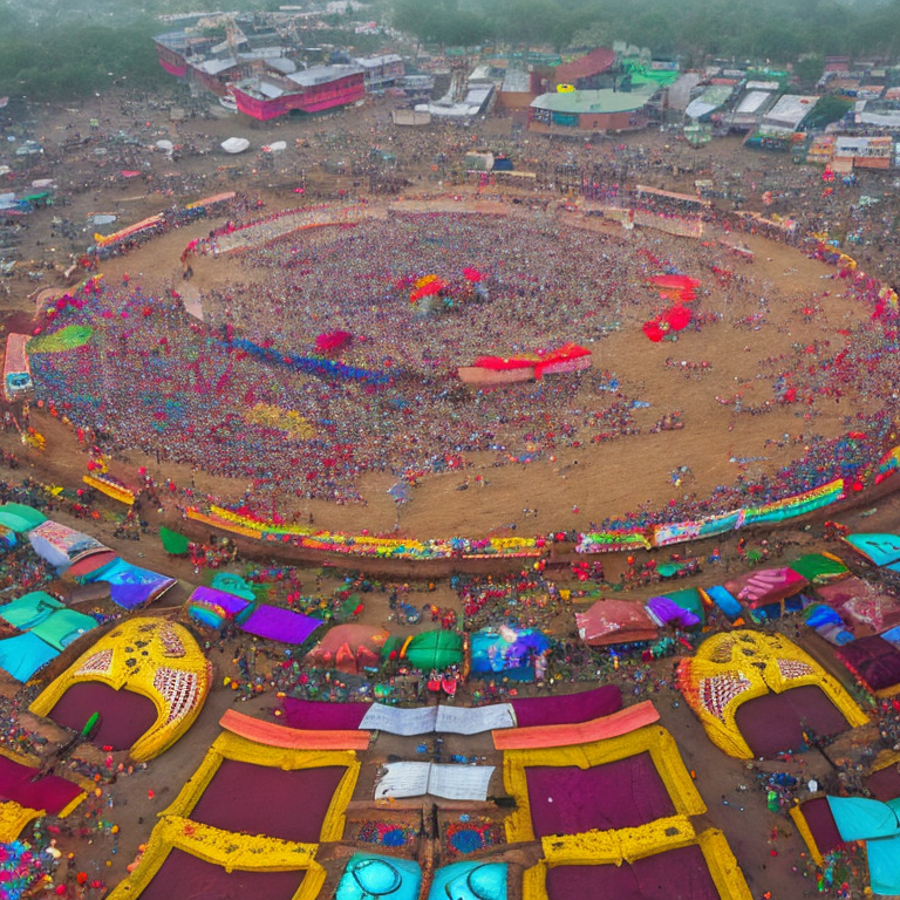

In [22]:
translation = get_translation("maha kumb mela drone images","en")
generate_image(translation, image_gen_model)